# Air Quality Data Hack

## Visualise OpenAQ Leeds data
This notbook follows on from the `download_openaq_leeds.ipynb` notebook, where we downloaded air quality pollutant data from the OpenAQ API. In this notebook, we will load in the data we previously downloaded, then perform some simple analysis and visualise the data

### Load the downloaded OpenAQ data
In the previous notebook we saved the data in the `./data/` directory. If the download was taking too long, or did not work as intended, change the path to `./data_prepared_earlier/` in the code cells below.

The below code opens all the .csv files and merges them into a single DataFrame with a hierachical column structure. In `pandas` this is called a `MultiIndex`. A `MultiIndex` allows you to flexibly select the data you need while keeping your code readable.

In [1]:
import pandas as pd
import os
idx = pd.IndexSlice
import matplotlib.pyplot as plt
# the 'idx' class makes it easy to select the data

# retrieve the metadata downloaded from the API
metadata = pd.read_csv('./leeds_locations.csv', index_col='name')
# fix the unicode error
#metadata['name'] = metadata.index.str.replace('&amp;','&')

# get a list of the data filenames
data_filenames = os.listdir('./data/')

# loop through the files, opening and formatting each one, and adding them to a list
loaded_data = []
for filename in data_filenames:

    location_id = int(filename.split('_')[1])
    location_name = metadata.loc[metadata.id == location_id].index[0]
    location_data = pd.read_csv(f'./data/{filename}',
                               index_col='datetime', # set the datetime column as the row index
                                parse_dates=True) # format the datetime column as datetimes
                                                  # by default it will be a text string

    # create the hierachical MultiIndex for the columns
    multiindex = pd.MultiIndex.from_product([ [location_name], location_data.columns ])
    location_data.columns = multiindex

    loaded_data.append(location_data)

# this is our dataframe of all the data
df = pd.concat(loaded_data, axis=1)

print(df.head())

                          SL060 Middleton Parl  ... SL068 - Bracken Edge Primary
                                           pm1  ...                         pm25
datetime                                        ...                             
2016-02-27 20:00:00+00:00                  NaN  ...                          NaN
2016-02-27 21:00:00+00:00                  NaN  ...                          NaN
2016-02-27 22:00:00+00:00                  NaN  ...                          NaN
2016-02-27 23:00:00+00:00                  NaN  ...                          NaN
2016-02-29 00:00:00+00:00                  NaN  ...                          NaN

[5 rows x 151 columns]


This shows the two levels of the DataFrame's columns index, the DataFrame can now be index using either. For example, to plot all the data from the 'St Stepen's Roof' location:

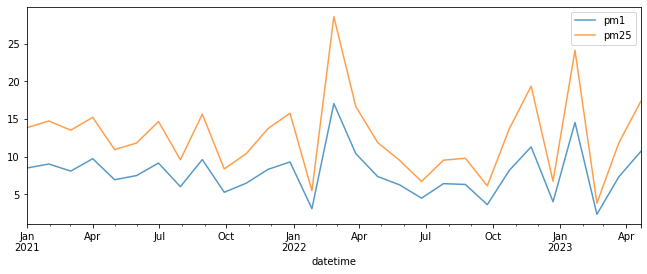

In [2]:
# select the desired location (quote mark must be escaped)
# resample to take the monthly mean and make the plot less busy
df['St Stephen\'s Roof'].resample('30D').mean().dropna().plot(alpha=.75, figsize=[11,4])

plt.savefig('./figs/st_stephen.png', dpi=300, bbox_inches='tight')

Or, to use the second level of the MultiIndex, and plot all the NO2 data:

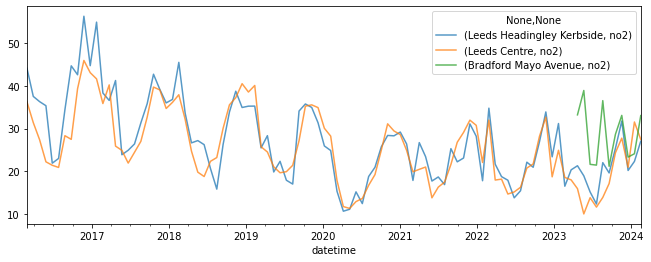

In [3]:


# the .loc syntax usually is: 
# .loc[row_index, column_index]
# but since we have two levels of column index it now is:
# .loc[row_index, idx[first_level_column_index, second_level_column_index]]
# a ':' (colon) means 'select all'

df.loc[:, idx[:, 'no2']].resample('30D').mean().plot(alpha=.75,
                              figsize=[11,4])

plt.savefig('./figs/no2_data.png', dpi=300, bbox_inches='tight')

### Making a map of the locations

We can use the `geopandas` module and the metadata we downloaded to map the locations, and `contextily` to provide background tiles

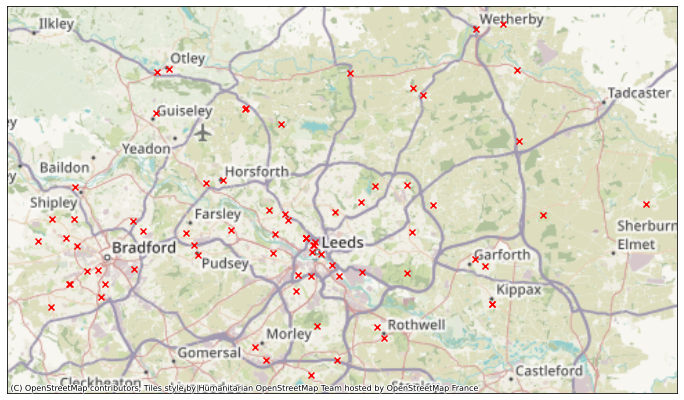

In [4]:
import geopandas as gpd
import contextily as cx

# make a geodataframe from the metadata
gdf = gpd.GeoDataFrame(
    metadata, 
    # tell geopandas that the x,y coordinates are in these columns
    geometry=gpd.points_from_xy(metadata['coordinates.longitude'], 
                                metadata['coordinates.latitude']),
    # tell geopandas that they are latitude/longitude coordinates
    crs="EPSG:4326"
)

# convert the data to the same coordinate reference system (CRS) as the OpenStreemap tile
gdf = gdf.to_crs(epsg=3857)

ax = gdf.plot(figsize=(12,8), color='red', marker='x')
# add OpenStreetmap tile
cx.add_basemap(ax, crs=gdf.crs, zoom=10)

# remove the x and y ticks
ax.set_xticks([])
ax.set_yticks([])

plt.savefig('./figs/station_locations_map.png', dpi=300, bbox_inches='tight')

We can make maps of other useful aspects of the data. Our dataset is a mix of low cost sensors from the 'Purpleair' network, and DEFRA operated sensors. The `'provider.name'` column in the `metadata` tells us which:

In [5]:
print(metadata['provider.name'])

name
Leeds Headingley Kerbside                            DEFRA
Bradford Mayo Avenue                                 DEFRA
Leeds Centre                                         DEFRA
ULeeds(SEE, North Bldg)                          PurpleAir
Brackenhill Primary School - Spruce Classroom    PurpleAir
                                                   ...    
SL050 - Bardsey                                  PurpleAir
SL041 - Knowsthorpe Gate                         PurpleAir
SL038 Ingram Road Primary                        PurpleAir
SL045 - Millenium Square (2)                     PurpleAir
SL047 The Quay                                   PurpleAir
Name: provider.name, Length: 76, dtype: object


We can use this column to set the shape of the marker easily using the geodataframe (`gdf`)

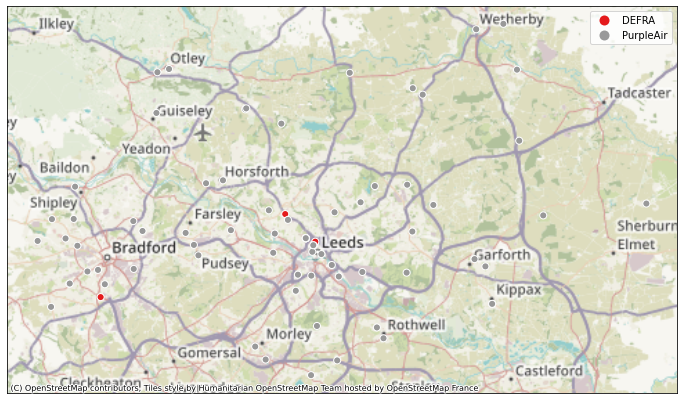

In [6]:
ax = gdf.plot(figsize=(12,8), column='provider.name', categorical=True,
             cmap='Set1', legend=True, edgecolor='white', markersize=50)
# add OpenStreetmap tile
cx.add_basemap(ax, crs=gdf.crs, zoom=10)

# remove the x and y ticks
ax.set_xticks([])
ax.set_yticks([])

plt.savefig('./figs/station_type_map.png', dpi=300, bbox_inches='tight')

We can also plot the number of years of data so we can see what is available for each site

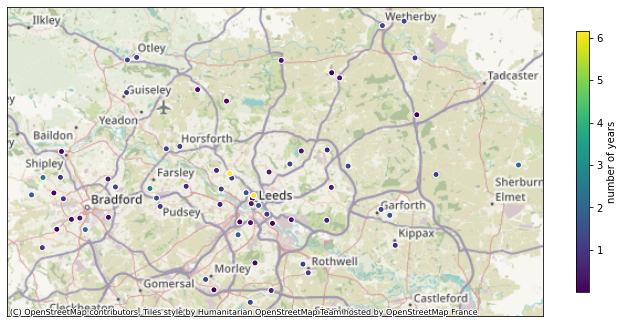

In [7]:
# get the number of years for PM2.5
hour_count_pm25 = df.loc[:, idx[:, 'pm25']].count()
year_count_pm25 = hour_count_pm25 / 24 / 365.25
# get rid of the second level of the multiindex
year_count_pm25.index = year_count_pm25.index.droplevel(1)

ax = gdf.loc[year_count_pm25.index].plot(figsize=(12,8), column=year_count_pm25,
                                        cmap='viridis', legend=True,
                                        edgecolor='white', 
                                         legend_kwds={'shrink':.6,'label':'number of years'})
# add OpenStreetmap tile
cx.add_basemap(ax, crs=gdf.crs, zoom=10)

# remove the x and y ticks
ax.set_xticks([])
ax.set_yticks([])

plt.savefig('./figs/years_of_data_map.png', dpi=300, bbox_inches='tight')

This map shows that the majority of the sites have 0-2 years of data available. The DEFRA stations have longer records. This is also easier to see on a quick graph:

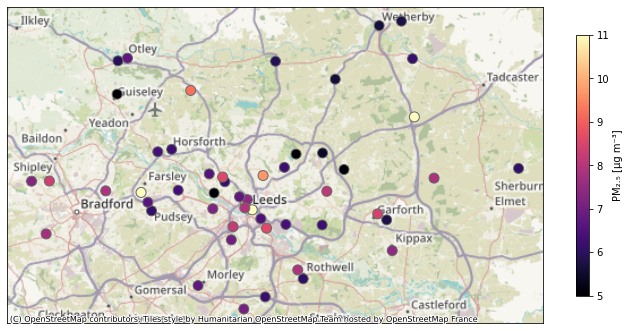

In [8]:
# get the average PM2.5 concentration during Nov 2023 - Jan 2024
timeslice = slice('2023-11-01', '2024-03-01')
mean_pm25 = df.loc[timeslice, idx[:, 'pm25']].mean()
# get rid of the second level of the multiindex
mean_pm25.index = mean_pm25.index.droplevel(1)

ax = gdf.loc[mean_pm25.index].plot(figsize=(12,8), column=mean_pm25,
                                        cmap='magma', legend=True,
                                        edgecolor='dimgrey', 
                                   legend_kwds={'shrink':.6, 'label':'PM₂.₅ [µg m⁻³]'},
                                  vmin=5, vmax=11, markersize=100,)
# add OpenStreetmap tile
cx.add_basemap(ax, crs=gdf.crs, zoom=10)

# remove the x and y ticks
ax.set_xticks([])
ax.set_yticks([])

plt.savefig('./figs/last_winter_pm25_map.png', dpi=300, bbox_inches='tight')

In a Jupyter notebook, you can easily produce an interactive map from the geodataframe:

In [9]:
gdf['location_name'] = gdf.index
gdf.explore(tooltip=['location_name'])

We can explore other patterns in the data, such as looking at the way pollution varies with season and hour of the day on average. Let's use the `Leeds Centre` station for this as it has the longest record and 4 different pollutants

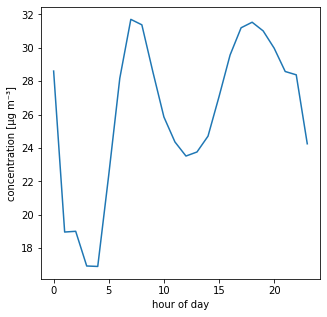

In [10]:


def plot_diurnal_cycle(sr, ax):
    hourly_mean = sr.groupby(sr.index.hour).mean()
    hourly_mean.plot(ax=ax)
    ax.set_xlabel('hour of day')
    ax.set_ylabel('concentration [µg m⁻³]')
    #ax.set_title(sr.name[0]+' '+sr.name[1])


# plot the diurnal cycle of NO2
fig, ax = plt.subplots(figsize=[5,5])
plot_diurnal_cycle(df.loc[:, idx['Leeds Centre', 'no2']],
                   ax=ax)

plt.savefig('./figs/no2_diurnal.png', dpi=300, bbox_inches='tight')

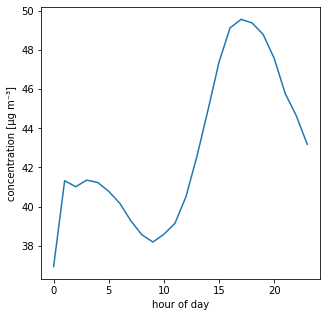

In [11]:
# plot the diurnal cycle of O3
fig, ax = plt.subplots(figsize=[5,5])
plot_diurnal_cycle(df.loc[:, idx['Leeds Centre','o3']],
                   ax=ax)

plt.savefig('./figs/o3_diurnal.png', dpi=300, bbox_inches='tight')

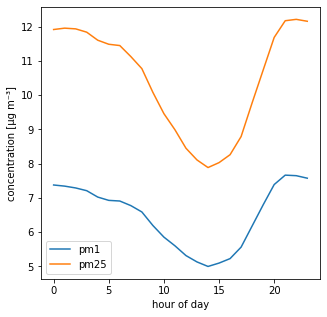

In [12]:
fig, ax = plt.subplots(figsize=[5,5])
plot_diurnal_cycle(df.loc[:, 'ULeeds(SEE, North Bldg)'],
                   ax=ax)

plt.savefig('./figs/ULeeds_pm.png', dpi=300, bbox_inches='tight')

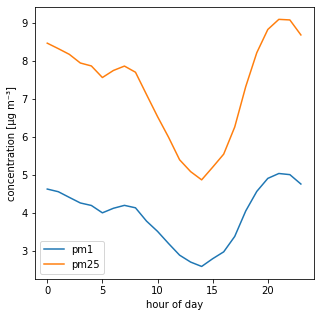

In [13]:
fig, ax = plt.subplots(figsize=[5,5])
plot_diurnal_cycle(df.loc[:, 'Church Fenton Out'],
                   ax=ax)

plt.savefig('./figs/Church Fenton_pm.png', dpi=300, bbox_inches='tight')

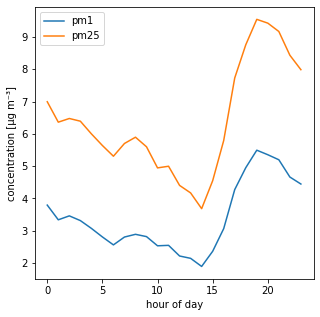

In [14]:
fig, ax = plt.subplots(figsize=[5,5])
plot_diurnal_cycle(df.loc[:, 'SL050 - Bardsey'],
                   ax=ax)

plt.savefig('./figs/Bardsey_pm_diurnal.png', dpi=300, bbox_inches='tight')

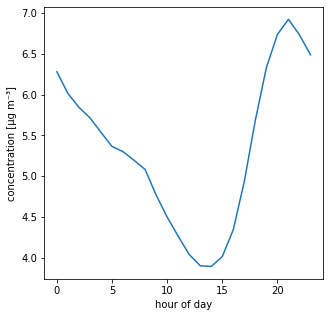

In [15]:
# average all the pm25 stations together
average = df.loc[:, idx[:, 'pm1']].mean(1)
fig, ax = plt.subplots(figsize=[5,5])
plot_diurnal_cycle(average,
                   ax=ax)

plt.savefig('./figs/average_pm1_diurnal.png', dpi=300, bbox_inches='tight')

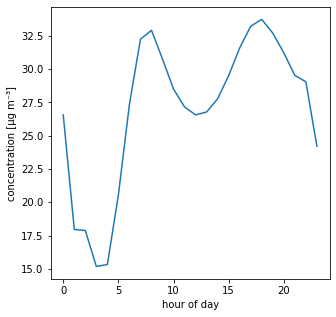

In [16]:
# average all the no2 stations together
average = df.loc[:, idx[:, 'no2']].mean(1)
fig, ax = plt.subplots(figsize=[5,5])
plot_diurnal_cycle(average,
                   ax=ax)

plt.savefig('./figs/average_no2_diurnal.png', dpi=300, bbox_inches='tight')

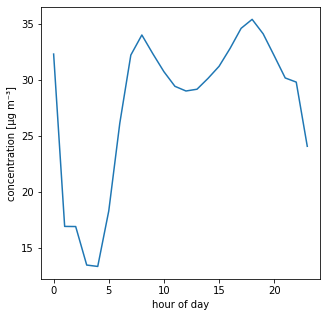

In [17]:
# plot diurnal cycle of NO2 at an urban location
average = df.loc[:, 'Leeds Headingley Kerbside']['no2']
fig, ax = plt.subplots(figsize=[5,5])
plot_diurnal_cycle(average,  ax=ax)

plt.savefig('./figs/Headingley_no2_diurnal.png', dpi=300, bbox_inches='tight')

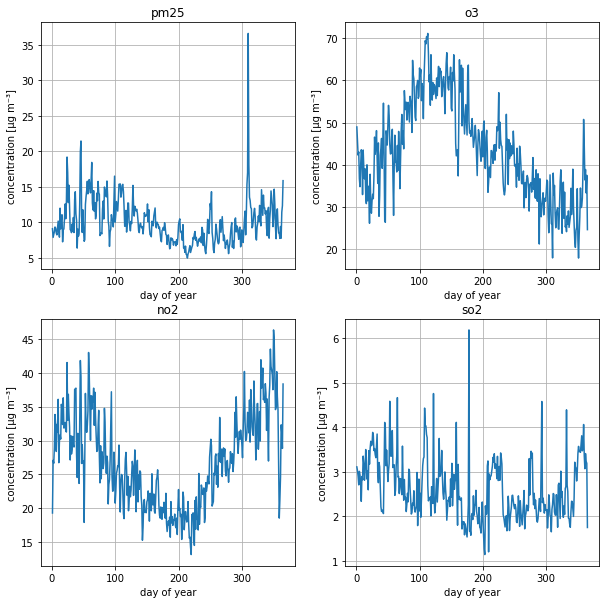

In [18]:
# average all the pm25 stations together

# get defra stations only
DEFRA_STATIONS = ['Leeds Headingley Kerbside',
                 'Bradford Mayo Avenue', 'Leeds Centre']


def get_seasonal_cycle(sr):
    sr = sr.resample('D').mean().mean(1)
    dayofyear_mean = sr.groupby(sr.index.dayofyear).mean()

    return dayofyear_mean


fig, axes = plt.subplots(2,2, figsize=[10,10])
for ax, pol in zip(axes.ravel(), ['pm25', 'o3', 'no2', 'so2']):
    seas_cyc = get_seasonal_cycle(df.loc[:, idx[DEFRA_STATIONS, pol]])
    seas_cyc.plot(ax=ax)
    ax.set_title(pol)
    ax.grid()
    ax.set_xlabel('day of year')
    ax.set_ylabel('concentration [µg m⁻³]')


plt.savefig('./figs/seasonal_cycles.png', dpi=300, bbox_inches='tight')


We can also see how different pollutants vary with meteorological variables

In [31]:
met = pd.read_csv('./weather_data/LBA_weather_data.csv', index_col='time',
                   parse_dates=True)
# add time zone
met.index = met.index.tz_localize('UTC')
# get rid of empty columns
met = met.dropna(how='all', axis=1)
# drop some other variables
met = met.drop(['dwpt', 'wdir', 'coco'], axis=1)



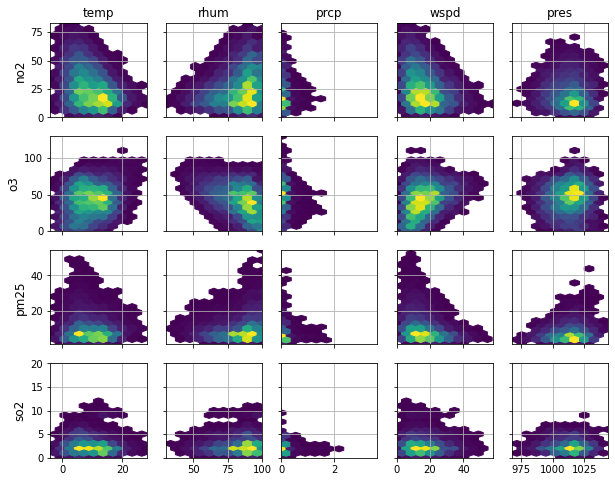

In [60]:
fig, axes = plt.subplots(4,5, sharex='col', sharey='row',
                        figsize=[10,8])

for pol, axrow in zip(['no2', 'o3', 'pm25', 'so2'], axes):
    for metvar, ax in zip(met.columns, axrow):
        comp_df = pd.concat([met[metvar], df.loc[:, 'Leeds Centre'][pol]], axis=1)
        # get rid of rows with any missing value
        comp_df = comp_df.dropna(how='any')
        #ax.scatter(x=comp_df[metvar], y=comp_df[pol], 
        #          marker='.', alpha=.01, color='black')

        xmin, xmax = comp_df[metvar].quantile(.001), comp_df[metvar].quantile(.999)
        ymin, ymax = comp_df[pol].quantile(.001), comp_df[pol].quantile(.999)
        
        ax.hexbin(x=comp_df[metvar], y=comp_df[pol],
                   gridsize=(10,10), mincnt=22, 
                 extent=(xmin, xmax, ymin, ymax))

        ax.set_xlim([xmin, xmax])
        ax.set_ylim([ymin, ymax])
        ax.grid()


# give each row and column a title
for ax, col in zip(axes[0], met.columns):
    ax.set_title(col)
for ax, row in zip(axes[:,0], ['no2', 'o3', 'pm25', 'so2']):
    ax.set_ylabel(row, size='large')
        
plt.savefig('./figs/met_correlations.png', dpi=300, bbox_inches='tight')     

In [ ]:
fig, ax = plt.subplots(figsize=[10,6])

df.loc[:, 'Leeds Centre']['no2'].rolling('365D', min_periods=220*24, center=True).mean()\
.plot(label='NO2 Leeds Centre')
df.loc[:, 'Leeds Centre']['o3'].rolling('365D', min_periods=220*24, center=True).mean()\
.plot(label='O3 Leeds Centre')
df.loc[:, 'Leeds Headingley Kerbside']['no2'].rolling('365D', min_periods=220*24, center=True).mean()\
.plot(label='NO2 Headingley Kerbside')


ax.legend()
ax.grid()
ax.set_ylabel('concentration [µg m⁻³]')

plt.savefig('./figs/no2_o2_trend.png', dpi=300, bbox_inches='tight')   

In [ ]:
fig, ax = plt.subplots(figsize=[10,6])

df.loc[:, 'Leeds Centre']['pm25'].rolling('365D', min_periods=220*24, center=True).mean()\
.plot(label='PM2.5 Leeds Centre')
df.loc[:, 'Leeds Headingley Kerbside']['pm25'].rolling('365D', min_periods=220*24, center=True).mean()\
.plot(label='PM2.5 Headingley Kerbside')

ax.legend()
ax.grid()
ax.set_ylabel('concentration [µg m⁻³]')

plt.savefig('./figs/pm25_trend.png', dpi=300, bbox_inches='tight')   